In [112]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [117]:
from os import getcwd
from os.path import join

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

In [114]:
work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "images")

In [3]:
fraud_data = pd.read_csv(join(data_dir, "fraud_data_country.csv"), index_col=0) 

## Preprocessing

In [81]:
quantile_list = [0, .25, .5, .75, 1.]

top5_country = ['United States', 'unknown', 'China', 'Japan', 'United Kingdom',
       'Korea Republic of']

def country_reduction(country):
    """
    Réduction du nombre de country au top5
    """
    if np.isin(country, top5_country):
        return country
    else:
        return "other"

def quantile_labels(feature_quantiles):
    """
    return the list of the feature quantiles labels
    """
    return [f"{int(feature_quantiles.iloc[q])}-{int(feature_quantiles.iloc[q+1])}" for q in range(len(feature_quantiles) - 1)]

def preprocessing(df, dummies_drop_first=True):
    """
    Procédure de préparation des features
    """
    
    # conversion de l'ip_address en int64
    df["ip_address"] = fraud_data["ip_address"].astype("int64")
    
    # time conversion
    df["signup_time"] = pd.to_datetime(df["signup_time"], infer_datetime_format=True)
    df["purchase_time"] = pd.to_datetime(df["purchase_time"], infer_datetime_format=True)
    
    # création de la feature délai signup purchase
    df["signup_purchase_timedelta"] = df["purchase_time"] - df["signup_time"]
    df["signup_purchase_timedelta"] = df["signup_purchase_timedelta"].dt.total_seconds() / 60
    
    # création de la feature jour de la semaine de la transaction
    df["purchase_weekday"] = df["purchase_time"].dt.weekday
    
    # création de la feature heure de la transaction
    df["purchase_hour"] = df["purchase_time"].dt.hour
    hour_quantiles = df["purchase_hour"].quantile(quantile_list)
    hour_bins_labels = quantile_labels(hour_quantiles)
    df["purchase_hour"] = pd.qcut(df["purchase_hour"], q=quantile_list, labels=hour_bins_labels)
    
    # discretisation Age
    age_quantiles = df["age"].quantile(quantile_list)
    age_bins_labels = quantile_labels(age_quantiles)
    df["age"] = pd.qcut(df["age"], q=quantile_list, labels=age_bins_labels)
    
     
    # réduction du nombre de classes de country
    df["country"] = df["country"].map(country_dummification)
    
    # dummification
    # sex, source, browser, age
    df = pd.get_dummies(df, 
                        columns=["sex", "source","browser", "age", "country", "purchase_weekday", "purchase_hour"], 
                        drop_first=dummies_drop_first)
    
    return df

In [75]:
df = preprocessing(fraud_data.copy(), False)

In [76]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'ip_address', 'class', 'signup_purchase_delta',
       'signup_purchase_timedelta', 'sex_F', 'sex_M', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'age_18-27',
       'age_27-33', 'age_33-39', 'age_39-76', 'country_China', 'country_Japan',
       'country_Korea Republic of', 'country_United Kingdom',
       'country_United States', 'country_other', 'country_unknown',
       'purchase_weekday_0', 'purchase_weekday_1', 'purchase_weekday_2',
       'purchase_weekday_3', 'purchase_weekday_4', 'purchase_weekday_5',
       'purchase_weekday_6', 'purchase_hour_0-6', 'purchase_hour_6-12',
       'purchase_hour_12-17', 'purchase_hour_17-23'],
      dtype='object')

In [98]:
time_features = [
    'signup_time',
    'purchase_time'
]

categorical = [
    'source_Ads',
#    'source_Direct', 
    'source_SEO', 
    'browser_Chrome',
#    'browser_FireFox', 
    'browser_IE', 
    'browser_Opera', 
    'browser_Safari', 
#    'sex_M',
    'sex_F',
    'country_China',
    'country_Japan', 
#    'country_Korea Republic of', 
    'country_United Kingdom',
    'country_United States', 
    'country_other', 
    'country_unknown',
    'age_18-27', 
    'age_27-33', 
    'age_33-39', 
#    'age_39-76',
#    'purchase_weekday_0', 
    'purchase_weekday_1', 
    'purchase_weekday_2',
    'purchase_weekday_3', 
    'purchase_weekday_4', 
    'purchase_weekday_5',
    'purchase_weekday_6', 
    'purchase_hour_0-6', 
    'purchase_hour_6-12',
    'purchase_hour_12-17', 
    'purchase_hour_17-23'
]

numerical = [
    'purchase_value',
    "signup_purchase_timedelta"
]

target = ["class"]

In [106]:
corr = df[numerical + categorical + target].corr()
np.abs(corr[["class"]]).sort_values(by="class", ascending=False)[:13]

,class
class,1.000000
signup_purchase_timedelta,0.257888
purchase_weekday_1,0.021337
source_Direct,0.020285
purchase_weekday_2,0.018608
browser_Chrome,0.014620
country_unknown,0.013636
browser_IE,0.013363
source_SEO,0.012251
age_18-27,0.012010


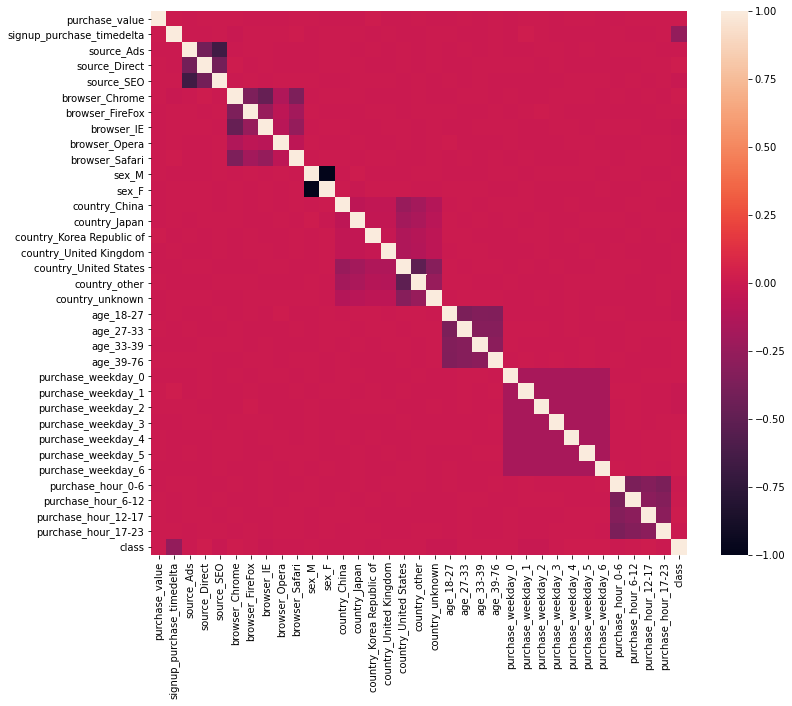

In [108]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, annot=False, ax=ax);

plt.show()

##### train test split

In [127]:
random.seed(42)

X = df[numerical + categorical]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [128]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120889, 34), (30223, 34), (120889, 1), (30223, 1))

##### standardisation

In [129]:
sc_X = StandardScaler().fit(X_train)
X_train = sc_X.transform(X_train)
X_test = sc_X.transform(X_test)

### Logistic Regression

In [161]:
%%notify

param_grid = {"C" : [0.05, 0.1]}

search = GridSearchCV(LogisticRegression(class_weight="balanced", n_jobs=-1), param_grid=param_grid, scoring="f1", cv=10, n_jobs=-1).fit(X_train, y_train.squeeze())
search.best_params_

{'C': 0.1}

<IPython.core.display.Javascript object>

In [162]:
logit = search.best_estimator_
scores = cross_val_score(logit, X_train, y_train, cv=10, n_jobs=-1)
scores.mean(), scores.std()

(0.6484792574146336, 0.004832726235196196)

In [163]:
y_pred = logit.predict(X_train)

In [164]:
cm = confusion_matrix(y_train, y_pred)

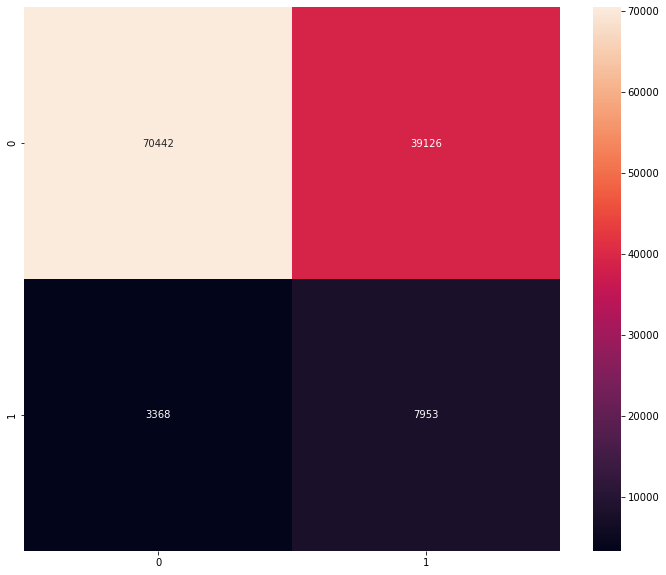

In [165]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(cm, annot=True, ax=ax, fmt="d");

plt.show()